# Poisson equation in a multipatch domain

In [3]:
%pylab inline
import scipy

from pyiga import bspline, assemble, vform, geometry, vis, solvers, topology

Populating the interactive namespace from numpy and matplotlib


/home/wolfman/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
# define discretization space (the same in each patch)
p = 3
kvs = 2 * (bspline.make_knots(p, 0.0, 1.0, 15),)

In [5]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.unit_square().translate((-1, 1)),
    geometry.quarter_annulus().rotate_2d(pi).translate((-1, 3)),
    geometry.quarter_annulus().rotate_2d(-pi/2).translate((-2, 1))
]

patches = [(kvs, g) for g in geos]

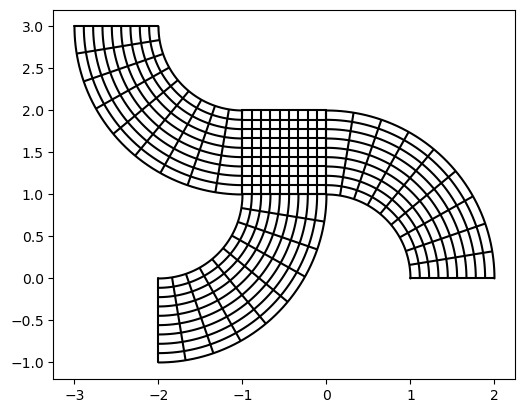

In [6]:
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [9]:
# source term f and Dirichlet boundary function g
f = lambda x, y: exp(-5 * ((x-0.3)**2 + (y-1)**2))
g = lambda x,y: 1e-1 * sin(8*x)

# set up Dirichlet boundary conditions
# dir_data = [
#     (0, 'bottom'), (0, 'right'),
#     (1, 'top'),
#     (2, 'left'), (2, 'bottom'),
#     (3, 'bottom')
# ]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().

M = topology.PatchMesh(patches)
MP = assemble.Multipatch(M, automatch=True)

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
A, rhs = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)

# generate Dirichlet data for global boundary dofs
dir_bcs = MP.compute_dirichlet_bcs({0:g})
N = MP.assemble_surface(vform.L2functional_vf(2, physical=True), f=0)

TypeError: __init__() got an unexpected keyword argument 'boundary'

In [19]:
# set up and solve linear system
LS = assemble.RestrictedLinearSystem(A, rhs, dir_bcs)

u = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

# restrict solution to each individual patch (kvs on every patch)
u_funcs = [geometry.BSplineFunc(kvs, MP.Basis[MP.N_ofs[p]:MP.N_ofs[p+1]] @ u)
           for p in range(len(patches))]

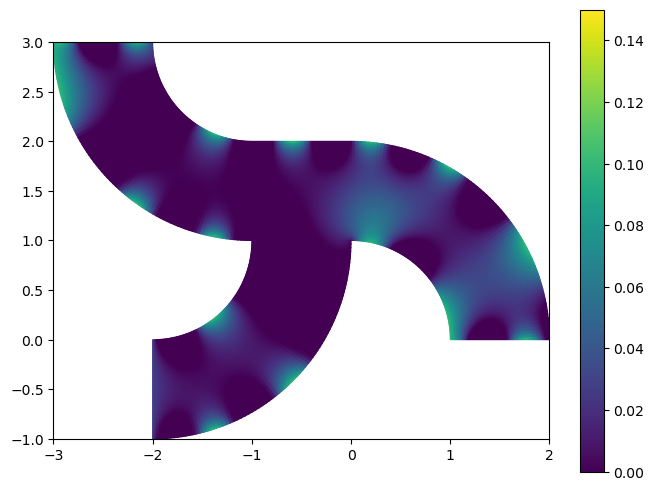

In [20]:
figsize(8,6)

for (u_func, (kvs, geo)) in zip(u_funcs, patches):
    vis.plot_field(u_func, geo, vmin=0, vmax=1.5e-1)
axis('scaled')
colorbar();

In [11]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.quarter_annulus().rotate_2d(pi/2),
    geometry.quarter_annulus().rotate_2d(pi),
    geometry.quarter_annulus().rotate_2d(3*pi/2),
]

patches = [(kvs, g) for g in geos]